## Analyze A/B Test Results


## Table of Contents
- Part I - Probability
- Part II - A/B Test
- Part III - Regression

### Part I - Probability

In [25]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
#number of rows in the dataset
df.shape[0]

294478

In [4]:
#number of unique users in the dataset
df.user_id.nunique()

290584

In [5]:
#proportion of users converted
df[~df.user_id.duplicated()].converted.mean()

0.1195695564793657

In [6]:
#number of times the new_page and treatment don't line up.
x=df.query(" group=='treatment' and landing_page!='new_page' ").shape[0]
y=df.query(" landing_page=='new_page' and group!='treatment' ").shape[0]

In [7]:
x+y

3893

In [8]:
# There is no missing values in any columns 

In [9]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [10]:
#doing dataframe to test
aux1= df.query("landing_page=='new_page' and group=='treatment'")
aux2= df.query("landing_page=='old_page' and group=='control'")

In [11]:
df2 = pd.concat([aux1,aux2], ignore_index=True)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [12]:
# double check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [13]:
#unique user_ids are in df2
df2.user_id.nunique()

290584

In [14]:
# duplicated id
df2[df2.user_id.duplicated()].user_id.count()

1

In [15]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
#delete duplicates
df2.drop_duplicates(subset='user_id', keep='first', inplace=True)
df2.shape

(290584, 5)

In [17]:
#probability of an individual converting regardless of the page
df2.converted.mean()

0.11959708724499628

In [18]:
#probability of an individual converting in control group
cg= round(df2[df2.group=='control'].converted.mean() , 4)
cg

0.1204

In [19]:
##probability of an individual converting in treatment group
tg=round(df2[df2.group=='treatment'].converted.mean(), 4)
tg

0.1188

In [20]:
# probability that an individual received the new page
df2.landing_page.value_counts()['new_page'] / df2.landing_page.count()

0.5000619442226688

**There is no evidence that a individual tends to get the new page as the yours favorite.
The probability of treatment group was even smaller than control group, considering the proportion of both sizes groups are almost equals ,50% for each, approximately. **

### Part II - A/B Test

*The null and alternative hypothesis*

**Ho:Pnew <= Pold**

**H1:Pnew > Pold**

In [21]:
# rate of convertions, regardless of page 
r=round(df2.converted.mean(),4)
r

0.1196

In [22]:
# sampling distribution for the difference in converted between the two pages over 10,000 ...
# ...iterations of calculating an estimate from the null

diffs=[]

for _ in range(10000):
    ex = df2.sample(df2.shape[0], replace=True)
    new = ex[ex.landing_page=='new_page']
    old = ex[ex.landing_page=='old_page']
    diffs.append(new.converted.mean() - old.converted.mean())  

In [37]:
diffs = np.array(diffs)

In [ ]:
#sns style charts
sns.set()

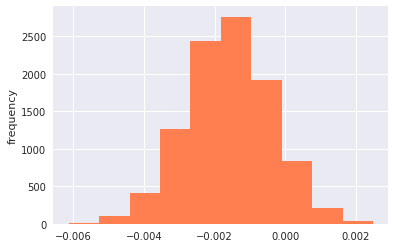

In [76]:
plt.hist(diffs, color='coral')
plt.ylabel('frequency')
plt.show()

In [39]:
#H1:Pnew - Pold > 0 
(diffs > 0).mean()

0.094

*This plot shows that old values are greater than new values in most of time*

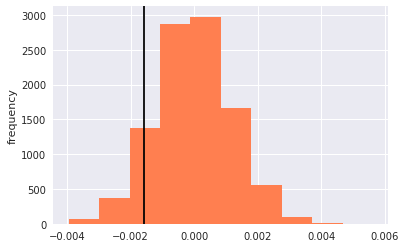

In [47]:
nulls = np.random.normal(0, diffs.std(), diffs.size)

plt.hist(nulls, color='coral')

plt.ylabel('frequency')

plt.axvline(x=diffs.mean(),color='black')
plt.show()

In [48]:
(nulls> (diffs.mean())).mean()

0.9087

***Thats suggests that we should not reject the null hypothesis***

In [49]:
#convert rate for  Pnew under the null
r

0.1196

In [50]:
# convert rate for  Pold  under the null
r

0.1196

In [51]:
#new number of users in treatment group
n_new=df2[df2.group=='treatment'].user_id.nunique()
n_new

145310

In [52]:
#new number of users in control group
n_old=df2[df2.group=='control'].user_id.nunique()
n_old

145274

In [63]:
# Simulate n_new transactions with a convert rate of  Pnew(r) under the null.
new_page_converted = np.random.choice([0,1], p=[1-r,r], size=n_new)
new_page_converted.mean()

0.12062487096552199

In [64]:
# Simulate n_old transactions with a convert rate of  Pold(r) under the null.
old_page_converted = np.random.choice([0,1], p=[1-r,r], size=n_old)
old_page_converted.mean()

0.11907154755840688

In [65]:
# Pnew - Pold for simulated values above
new_page_converted.mean() - old_page_converted.mean()

0.0015533234071151147

In [66]:
%%time
# Simulate 10,000  Pnew -  Pold values using pandas
p_diffs=[]
for _ in range(10000):
    ex = df2.sample(df2.shape[0], replace=True)
    npc= np.random.choice(ex[ex.group=='treatment'].converted , size=ex[ex.group=='treatment'].converted.count())
    opc= np.random.choice(ex[ex.group=='control'].converted, size=ex[ex.group=='control'].converted.count())
    p_diffs.append(npc.mean() - opc.mean())
  

CPU times: user 39min 12s, sys: 12.2 s, total: 39min 25s
Wall time: 39min 25s


In [69]:
p_diffs= np.array(p_diffs)

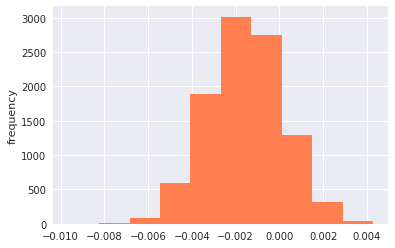

In [75]:
plt.hist(p_diffs , color='coral')
plt.ylabel('frequency')
plt.show()

In [71]:
#H1: Pnew-Pold > 0
(p_diffs > 0).mean()

0.1788

In [72]:
#  proportion of the p_diffs are greater than the actual difference observed in 'ab_data.csv'
dif = tg - cg

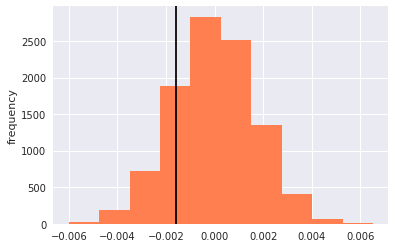

In [74]:
n = np.random.normal(0, p_diffs.std(), p_diffs.size)

plt.hist(n , color='coral')
plt.ylabel('frequency')

plt.axvline(x=dif, color='black')
plt.show()

In [77]:
#p-value
(n > p_diffs.mean()).mean()

0.8203

In [78]:
#response 
(n > dif).mean()

0.8255

**We just computed the p-value, which is the probability of getting the statistic test, or a more extreme value, under the null hypothesis.
  With alpha = 5%, then p-value = 0.82 > alpha, and we can't reject the null hypothesis.
  This value tell us that Ho is the best option, therefore Pnew<Pold.**

In [79]:
import statsmodels.api as sm

convert_old = df2.query(" group == 'control' and converted==1 ").user_id.nunique()
convert_new = df2.query(" group == 'treatment' and converted==1 ").user_id.nunique()
n_old = n_old
n_new = n_new

In [80]:
# using stats.proportions_ztest to compute your test statistic and p-value
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new] , alternative='larger')

In [81]:
z_score, p_value 

(1.3109241984234394, 0.09494168724097551)

In [82]:
from scipy.stats import norm

norm.cdf(z_score) #how significant is our z-score

0.9050583127590245

In [83]:
norm.ppf(1-(0.05/2)) #positive limit from a 95% confiance interval

1.959963984540054

**With a interval confidence of 95%, we have a critical value of 1.96.   The z-score(1.31) does not exceeds this value of 1.96. Then we could not reject the null hypothesis.   The p-value also is greater than 0.05, what give us other evidence for us dont reject the null hiypothesis. **


### Part III -  Regression

**The goal here is to use statsmodels to fit the regression model we specified in above parts.**

In [84]:
df3 = df2.copy()
df3['intercept']=1
df3['ab_page']= pd.get_dummies(df3.group).treatment #doing dummy of column group

In [85]:
df3.sample(4)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2448,712849,2017-01-09 18:53:35.889926,treatment,new_page,1,1,1
268689,932332,2017-01-22 10:51:19.208458,control,old_page,0,1,0
129329,640221,2017-01-11 15:22:56.677886,treatment,new_page,0,1,1
251196,718785,2017-01-18 16:20:18.966422,control,old_page,1,1,0


In [86]:
lr = sm.Logit(df3['converted'], df3[['intercept','ab_page']])

In [87]:
res = lr.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [88]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 07 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        00:09:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**P-value found for ab_page is 0.19 and it represents the measure of how compatible our data are with the null hypothesis.   The values are different because in part2 the null and alternative hypothesis are diferrent of part3, there in part2 we have a unicaudal statistic and here we have a bicaudal statistic.   That is why the values differ for each other in part2 and part3.**

**Here, Ho : there is no difference between Pnew and Pold and H1: Pnew and Pold are diferrent.  
  In part2, Ho : Pnew<=Pold and H1: Pnew > Pold**

**Increasing number of factors of a regression model, we can increase the information input of our algorithm, which can produce a better and more sophisticated output.   Also with this modeling, we can check if are confounding variables, that allow us to check if some variable is messing up our model.
  There are disadvantages if, for example, the new factors that have been inputed correlate with each others.
  If that happen, our predction model will not work as it should.   Other disadvantage is related to high dimensionality of our variables, that can saturate our model in complexity.**

In [89]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')

In [90]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [91]:
### Create the necessary dummy variables
df_new[['UK','US']] = pd.get_dummies(df_new.country)[['UK','US']]
# 'CA' will be 1 if UK and US are 0.

In [92]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


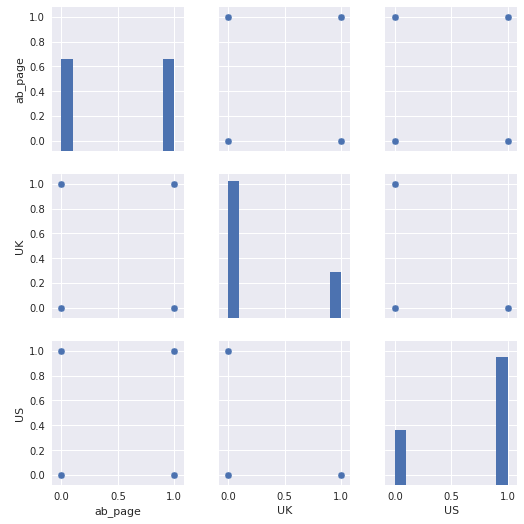

In [93]:
sns.pairplot(df_new[['ab_page','UK','US']])

***here, apparently, there is no correlation between these variables, which is good to our model by avoiding the multicollinearity.***

In [94]:
### Fit Your Linear Model And Obtain the Results
lr = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','UK','US']])

In [95]:
res = lr.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [96]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 07 May 2019   Pseudo R-squ.:               2.323e-05
Time:                        00:10:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

***Here, we can analyze two things.  
First: The p-values (except the intercept)are greater than 0.05, which show us that we cant reject the null hypothesis(Pnew=Pold)
Second: How the country variables have small p-values, but still are greater than 0.05,it means that we could not reject the summary function hypothesis that b1,b2,b3...bn = 0.  That is, at least the country variables coeficients are close to zero, and it means that this variables dont impact the convert decision. ***

In [97]:
# the converted chance is 1.015 times as likely on control group than treatment group, holding all else constant.
round(1/np.exp(-0.0149),3)

1.015

In [98]:
#intercept coef is the 'CA' coef when all others are 0.
# the converted chance is 7.614 times as likely on UK or US countries than CA country, holding all else constant.
round(1/np.exp(-2.03),3)

7.614

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(df_new[['ab_page','UK','US']],df_new['converted'] , test_size=0.3, random_state=42)

In [100]:
l = LogisticRegression()
l.fit(X_train,y_train)    
res= l.predict(X_test)

/home/joaovitordeon/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [101]:
#since having independents variables with low level of statistical significance, the logist regression model was able to work well
accuracy_score(res,y_test)

0.8804028631733505

**The various methods used above, such as A/B test and logistic regression, shows us that Pnew <= Pold.
   It means that the proportion of converted users on treatment group was insignificant, that is, the changes in the website from the new page was not significant in terms of conversion rate.**